In [1]:
import osmnx as ox
import folium
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import geopy.distance

In [2]:
def extract_munich_graph():
    # Define the place
    place = "Munich, Germany"

    # Extract the graph for the specified place
    graph = ox.graph_from_place(place, network_type='all')

    # Save the graph to a file or process it further
    # For example, to save as GraphML
    ox.save_graphml(graph, filepath="data/munich_street_network.graphml")

    return graph

def extract_closeup_munich_graph(bbox):
    graph = ox.graph_from_bbox(bbox[0], bbox[2], bbox[1], bbox[3], network_type='drive', simplify=True)
    ox.save_graphml(graph, filepath="data/munich_closeup_street_network.graphml")
    return graph

def read_munich_map():
    graph = ox.load_graphml("../data/munich_street_network.graphml")
    return graph

# Extract and process the graph
# munich_graph = read_munich_map()

bbox = [48.178301, 11.479089, 48.126705, 11.585432]

munich_graph = extract_closeup_munich_graph(bbox)
print("Number of nodes:", munich_graph.number_of_nodes())
print("Number of edges:", munich_graph.number_of_edges())

Number of nodes: 3010
Number of edges: 7419


Number of accidents: 8522


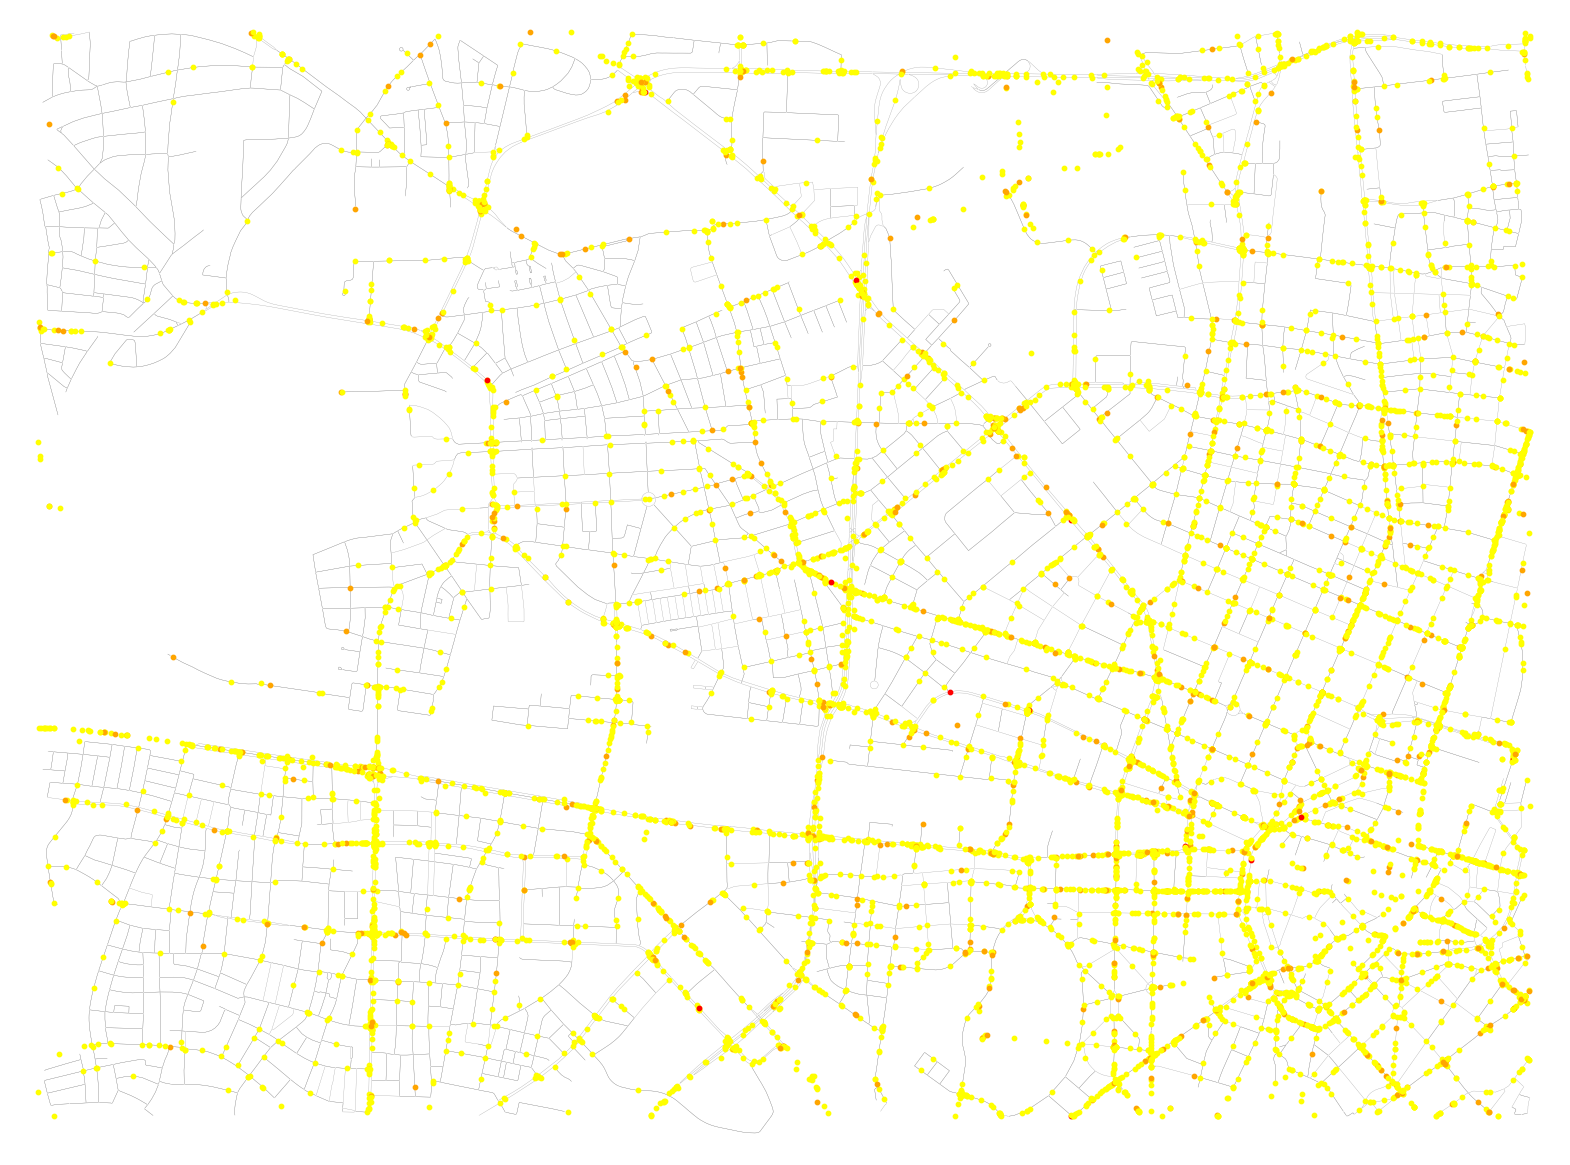

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
fig, ax = ox.plot.plot_graph(munich_graph, node_size=0.4, edge_linewidth=0.2,ax = ax, show=False, close=False)

color_map = ['red','orange','yellow']

# accident_coords_low = pd.read_csv("../data/accidents_low.csv")
# accident_coords_medium = pd.read_csv("../data/accidents_medium.csv")
# accident_coords_high = pd.read_csv("../data/accidents_high.csv")

# accident_coords = pd.concat([accident_coords_low, accident_coords_medium, accident_coords_high])

accident_coords = pd.read_csv("../data/munich_accidents_2018_2022.csv")

accident_coords = accident_coords[accident_coords['YGCSWGS84'] < bbox[0]]
accident_coords = accident_coords[accident_coords['YGCSWGS84'] > bbox[2]]
accident_coords = accident_coords[accident_coords['XGCSWGS84'] > bbox[1]]
accident_coords = accident_coords[accident_coords['XGCSWGS84'] < bbox[3]]

print("Number of accidents:", accident_coords.shape[0])
#plot point of interest
for index, row in accident_coords.iterrows():
    ax.scatter(row['XGCSWGS84'],row['YGCSWGS84'], c=color_map[int(row['UKATEGORIE'])-1], s=10,zorder=3)


In [173]:

def nodes_within_distance(graph,coords, distance_threshold):
    """
    Find all nodes within a certain Euclidean distance of a specified node.

    :param graph: The graph containing the nodes.
    :param node_id: The ID of the specified node.
    :param distance_threshold: The distance threshold.
    :return: A list of node IDs within the specified distance.
    """
    nodes_within_dist = []
    # Get the (latitude, longitude) of the specified node

    for node in graph.nodes:
        node_coords = (graph.nodes[node]['y'], graph.nodes[node]['x'])
        dist = geopy.distance.geodesic(coords, node_coords)
        if dist <= distance_threshold:
            nodes_within_dist.append(node)

    return nodes_within_dist

def assign_accidents_to_nodes(graph, accident_coords,dist_inter=10):
    # Initialize all nodes with 'num_accidents' attribute set to 0
    for node in graph.nodes:
        graph.nodes[node]['num_accidents'] = 0

    for edge in graph.edges:
        graph.edges[edge]['num_accidents'] = 0

    for index, row in accident_coords.iterrows():
        print(index)
        # Find the nearest nodes to each accident coordinate
        n_assigned_nodes = 0
        coords = (row['XGCSWGS84'], row['YGCSWGS84'])
        for node in graph.nodes:
            node_coords = (graph.nodes[node]['x'], graph.nodes[node]['y'])
            dist = geopy.distance.geodesic(coords, node_coords).m

            if dist <= dist_inter:
                # print("Found node within distance:", dist)
                print(coords)
                print(node_coords)

                graph.nodes[node]['num_accidents'] += 1
                n_assigned_nodes += 1

        if n_assigned_nodes == 0:
            nearest_edge,dist = ox.nearest_edges(graph, X=coords[0], Y=coords[1], return_dist=True)
            if dist < 10:
                graph.edges[nearest_edge]['num_accidents'] += 1

    return graph

accident_coords_sub = accident_coords[30:60]



# Assign the accident counts to the nodes
# munich_graph_accident = assign_accidents_to_nodes(munich_graph, accident_coords, dist_inter=50)
# munich_graph_accident_5 = assign_accidents_to_nodes(munich_graph, accident_coords, dist_inter=5)
# ox.save_graphml(munich_graph_accident, filepath="data/munich_street_network_accident_50.graphml")
munich_graph_accident = ox.load_graphml("data/munich_street_network_accident.graphml")

for node in munich_graph_accident.nodes:
    munich_graph_accident.nodes[node]['num_accidents'] = int(munich_graph_accident.nodes[node]['num_accidents'])
    
for edge in munich_graph_accident.edges:
    munich_graph_accident.edges[edge]['num_accidents'] = int(munich_graph_accident.edges[edge]['num_accidents'])

In [201]:
#get the nodes coordinates
import numpy as np
from sklearn.neighbors import BallTree
import geopy.distance

def create_tree_from_nodes(nodes):
    """
    Create a BallTree from nodes.

    :param nodes: List of (latitude, longitude) tuples.
    :return: BallTree object.
    """
    # Convert (lat, lon) to radians for the BallTree
    nodes_rad = np.radians(nodes)
    return BallTree(nodes_rad, metric='haversine')

def find_neighbors_for_route(route, tree, radius):
    """
    Find neighbors for each point in the route within a specified radius.

    :param route: List of (latitude, longitude) tuples representing the route.
    :param tree: BallTree object for neighbor search.
    :param radius: Radius in meters.
    :return: List of lists containing neighbor indices for each route point.
    """
    neighbors = []
    for point in route:
        point_rad = np.radians([point])
        # Find indices of points within the specified radius (convert radius to radians)
        indices = tree.query_radius(point_rad, r=radius/6371000.0)[0]
        # Filter by exact distance using geopy
        exact_neighbors = [i for i in indices if geopy.distance.distance(point, nodes[i]).meters <= radius]
        neighbors.append(exact_neighbors)
    return neighbors

# Example usage:
x_nodes = [munich_graph_accident.nodes[node]['x'] for node in munich_graph_accident.nodes]
y_nodes = [munich_graph_accident.nodes[node]['y'] for node in munich_graph_accident.nodes]
nodes = list(zip(x_nodes, y_nodes))
radius = 10

tree = create_tree_from_nodes(nodes)
route_neighbors = find_neighbors_for_route(nodes, tree, radius)

accident_xy = accident_coords[['XGCSWGS84','YGCSWGS84']].values
accident_neighbors = find_neighbors_for_route(accident_xy, tree, radius)

node_ids = list(munich_graph_accident.nodes)

for node in munich_graph_accident.nodes:
    munich_graph_accident.nodes[node]['num_accidents'] = 0

# for edge in munich_graph_accident.edges:
#     munich_graph_accident.edges[edge]['num_accidents'] = 0

for i in range(len(accident_neighbors)):
    if i % 100 == 0:
        print(f"Accident {i}/{len(accident_neighbors)}")
    neighbors = accident_neighbors[i]
    # print(accident)
    if len(neighbors) == 0:
        nearest_edge,dist = ox.nearest_edges(munich_graph_accident, X=accident_xy[i][0], Y=accident_xy[i][1], return_dist=True)
        if dist < 10:
            munich_graph_accident.edges[nearest_edge]['num_accidents'] += 1
        
    for ngb_rank in neighbors:
        munich_graph_accident.nodes[node_ids[ngb_rank]]['num_accidents'] += 1

Accident 0/1703
Accident 1/1703
Accident 2/1703
Accident 3/1703
Accident 4/1703
Accident 5/1703
Accident 6/1703
Accident 7/1703
Accident 8/1703
Accident 9/1703
Accident 10/1703
Accident 11/1703
Accident 12/1703
Accident 13/1703
Accident 14/1703
Accident 15/1703
Accident 16/1703
Accident 17/1703
Accident 18/1703
Accident 19/1703
Accident 20/1703
Accident 21/1703
Accident 22/1703
Accident 23/1703
Accident 24/1703
Accident 25/1703
Accident 26/1703
Accident 27/1703
Accident 28/1703
Accident 29/1703
Accident 30/1703
Accident 31/1703
Accident 32/1703
Accident 33/1703
Accident 34/1703
Accident 35/1703
Accident 36/1703
Accident 37/1703
Accident 38/1703
Accident 39/1703
Accident 40/1703
Accident 41/1703
Accident 42/1703
Accident 43/1703
Accident 44/1703
Accident 45/1703
Accident 46/1703
Accident 47/1703
Accident 48/1703
Accident 49/1703
Accident 50/1703
Accident 51/1703
Accident 52/1703
Accident 53/1703
Accident 54/1703
Accident 55/1703
Accident 56/1703
Accident 57/1703
Accident 58/1703
Acciden

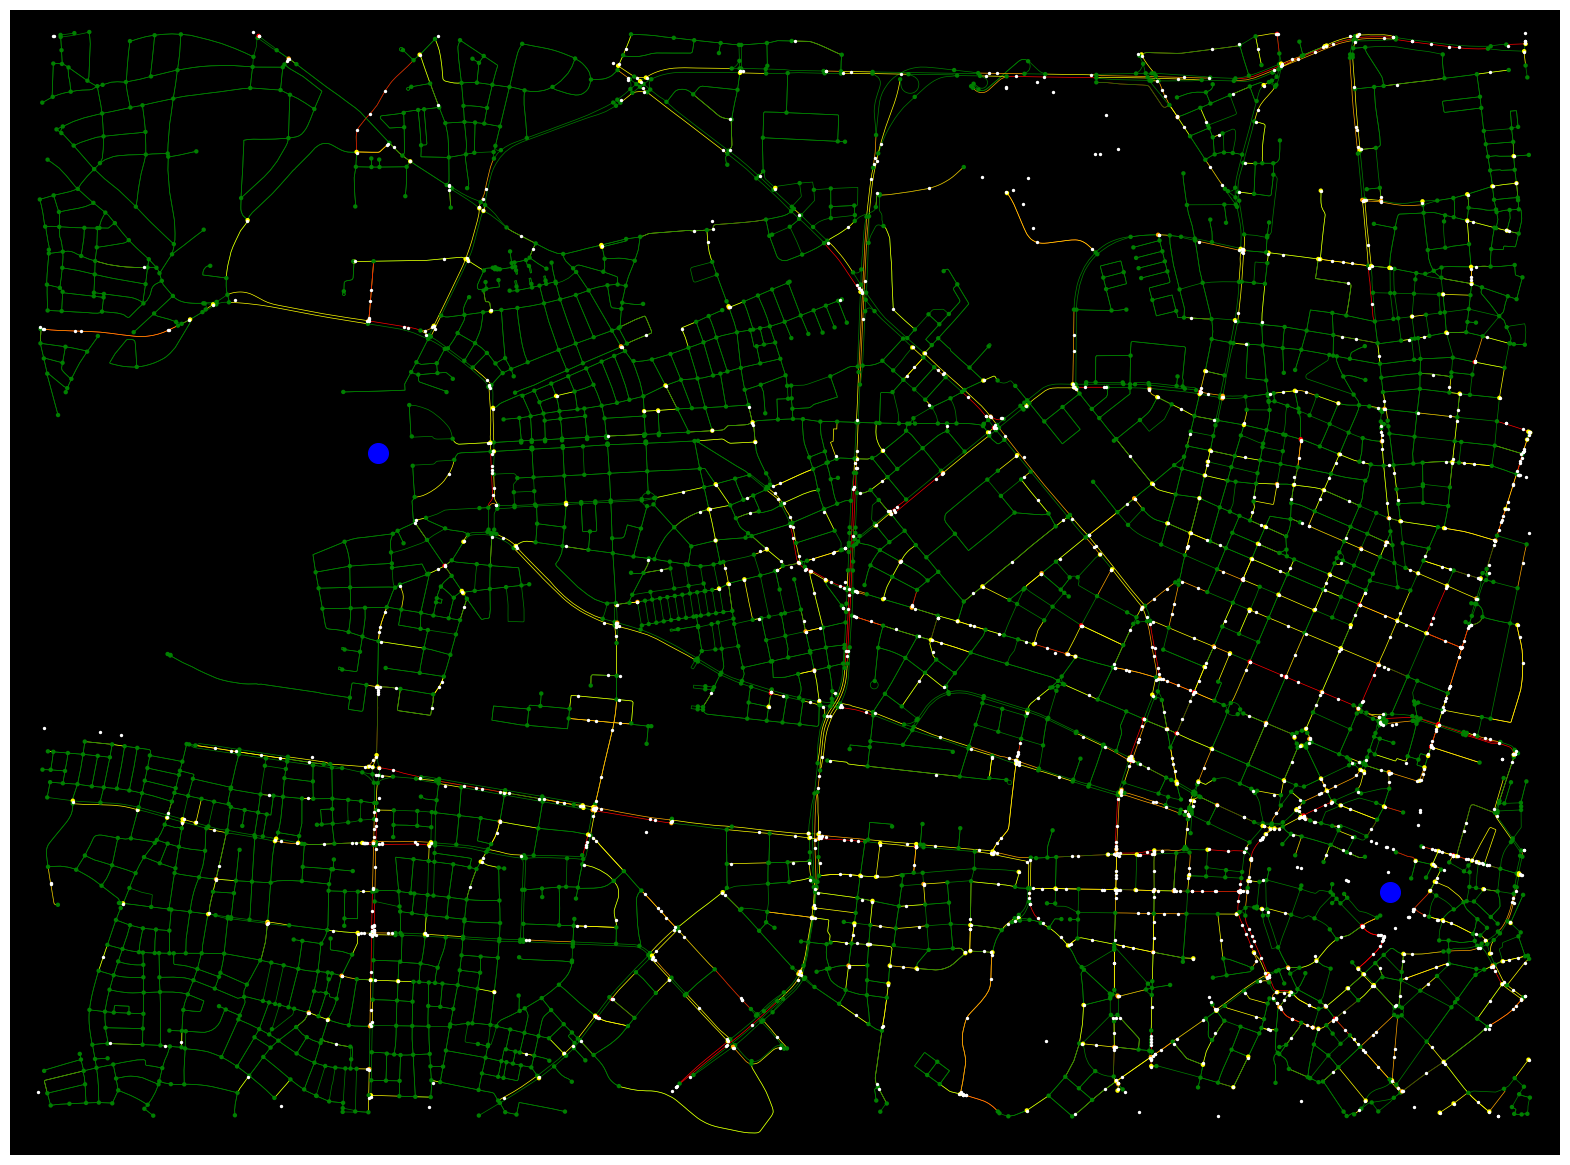

In [175]:
def get_colors_by_accidents(graph):
    node_colors = []
    edge_colors = []

    for node, data in graph.nodes(data=True):
        num_accidents = data.get('num_accidents', 0)

        if num_accidents == 0:
            color = 'green'  # No accidents
        elif num_accidents <= 1:
            color = 'yellow'  # Few accidents
        elif num_accidents <= 2:
            color = 'orange'  # Moderate accidents
        else:
            color = 'red'  # Many accidents
        node_colors.append(color)
    for u, v, data in graph.edges(data=True):
        num_accidents = data.get('num_accidents', 0)
        if num_accidents == 0:
            color = 'green'
        elif num_accidents <= 1:
            color = 'yellow'
        elif num_accidents <= 2:
            color = 'orange'
        else:
            color = 'red'
        edge_colors.append(color)
    return node_colors, edge_colors

    
# Assuming 'graph' is already processed with accident data
# graph = assign_accidents_to_nodes(graph, accident_coords)

# Get the node colors based on the number of accidents
node_colors, edge_colors = get_colors_by_accidents(munich_graph_accident)

# Plot the graph
# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
# fig, ax = ox.plot.plot_graph(munich_graph_accident, node_color=node_colors, node_size=0.4, edge_linewidth=0.2,ax = ax, show=False, close=False)

fig, ax = ox.plot_graph(munich_graph_accident, node_color=node_colors, edge_color=edge_colors,figsize=(20, 20), node_size=10, edge_linewidth=0.5, show=False, close=False,bgcolor='black')
ax.scatter(accident_coords['XGCSWGS84'],accident_coords['YGCSWGS84'], c="white", s=2,zorder=3, alpha=1)
fig.savefig('munich_accident.png', dpi=300)

# Plot departure and arrival points
marienplatz = (11.575448,48.137393)
nympenburg = (11.503314,48.158268)
ax.scatter(marienplatz[0],marienplatz[1], c="blue", s=200,zorder=3)
ax.scatter(nympenburg[0],nympenburg[1], c="blue", s=200,zorder=3)



In [16]:
from openrouteservice import client
from hackaton_directions import *

api_key = '5b3ce3597851110001cf6248f542525fba9142fda869c4da4b458f4b'  # Individual api key
ors = client.Client(key=api_key)  # Create client with api key

centerpoint = ((marienplatz[1]+nympenburg[1])/2,(marienplatz[0]+nympenburg[0])/2)

map_params = {'tiles': 'OpenStreetMap',
              'location': centerpoint,
              'zoom_start': 13.5}



map = folium.Map(**map_params)
route, summary = driving_directions(ors, marienplatz, nympenburg)

folium.PolyLine(locations=[(y, x) for x, y in route], 
                name='Route without construction sites',
                color='#FF0000',
                weight = 4,
                overlay=True).add_to(map)

map 

In [196]:
def route_to_graph_node(route):
    nodes = []
    nodes_xy = []
    for coord in route:
        node, dist = ox.nearest_nodes(munich_graph_accident, X=coord[0], Y=coord[1],return_dist=True)
        if dist < 0.1:
            nodes.append(node)
            nodes_xy.append((munich_graph_accident.nodes[node]['x'],munich_graph_accident.nodes[node]['y']))
        # graph.neighbors(start_node)
    return nodes, nodes_xy

route_nodes,route_xy = route_to_graph_node(route)
route_edges = list(zip(route_nodes[:-1], route_nodes[1:]))

def get_route_accidents(graph, route_nodes,accident_type='num_accidents'):
    route_edges = list(zip(route_nodes[:-1], route_nodes[1:]))
    edge_accidents_list = [data.get(accident_type, 0) if (u, v) in route_edges or (v, u) in route_edges else 0 for u, v, data in graph.edges(data=True)]
    nodes_accidents_list = [data.get(accident_type, 0) if node in route_nodes else 0 for node, data in graph.nodes(data=True)]
    total_accidents = sum(edge_accidents_list) + sum(nodes_accidents_list)
    return total_accidents

total_accidents = get_route_accidents(munich_graph_accident, route_nodes)
print("Total number of accidents:", total_accidents)

Total number of accidents: 88


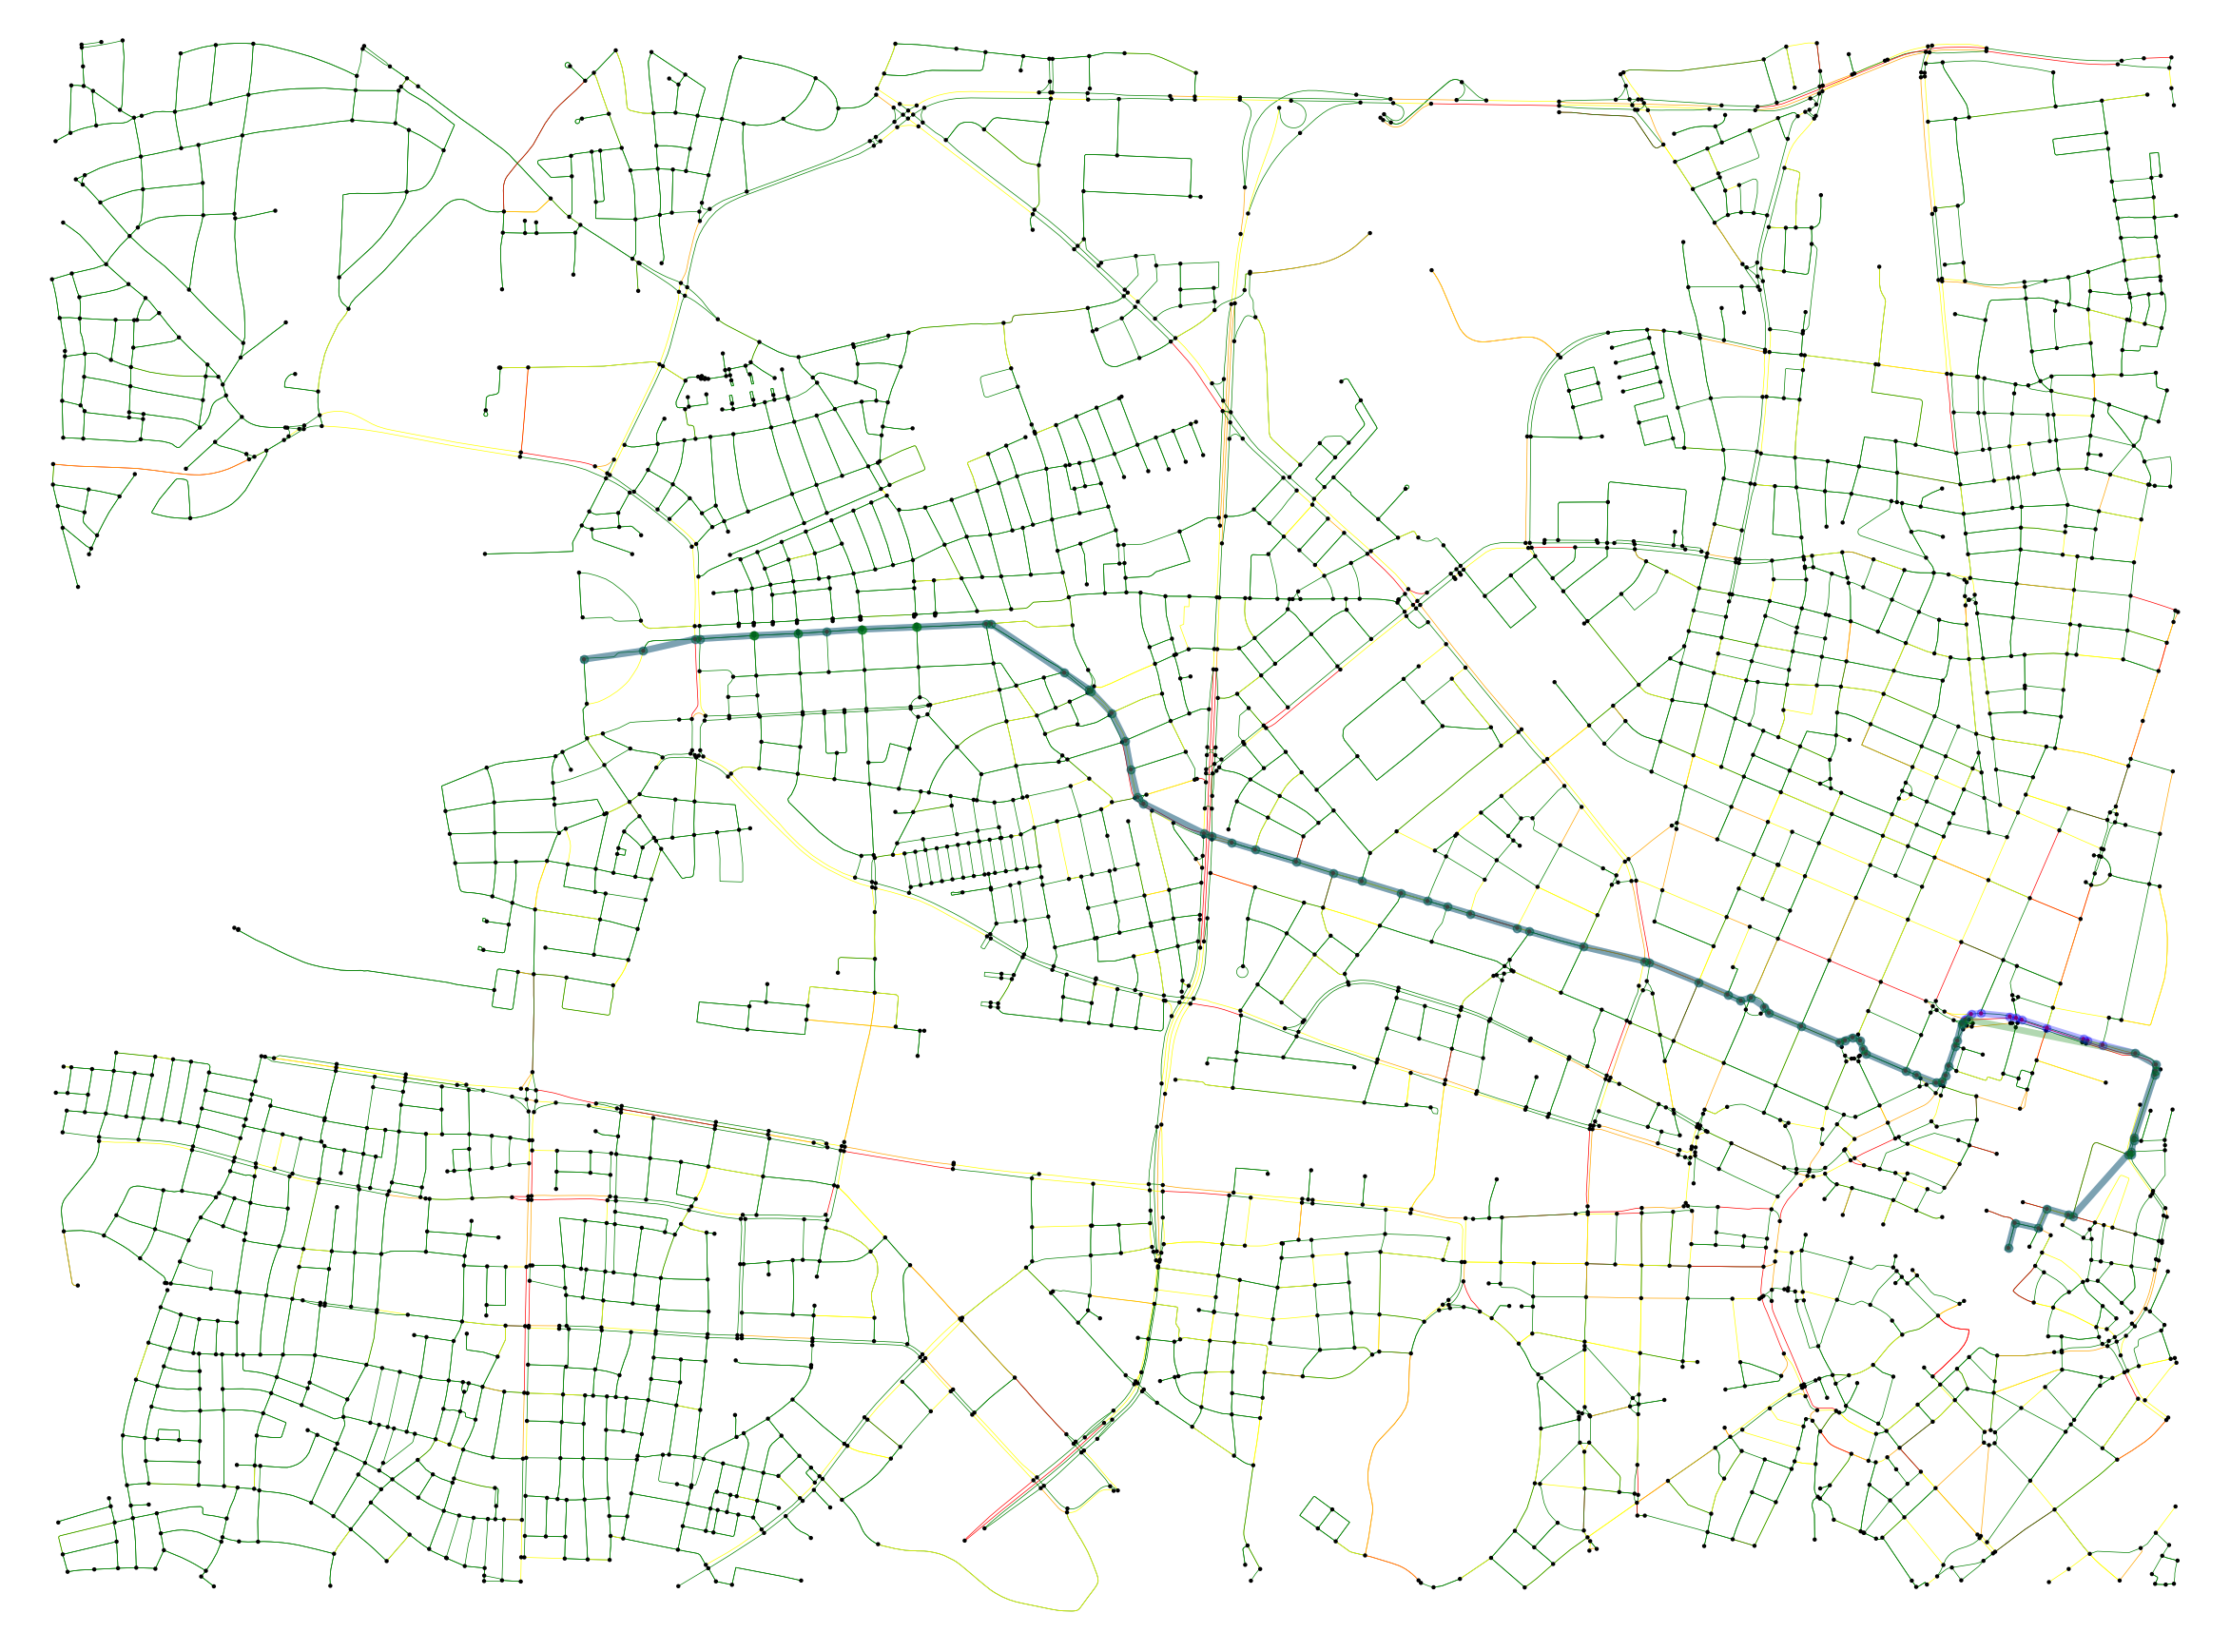

In [182]:
edge_colors_route = ['red' if (u, v) in route_edges or (v, u) in route_edges else 'black' for u, v, k in munich_graph_accident.edges(keys=True)]
node_colors_route = ['red' if node in route_nodes else 'black' for node in munich_graph_accident.nodes()]

# Plot the graph
# fig, ax = ox.plot_graph(munich_graph_accident, node_color=node_colors, edge_color=edge_colors,figsize=(15, 15), node_size=10, edge_linewidth=1, show=False, close=False,bgcolor='black')

# fig, ax = plt.subplots(1, 1, figsize=(20, 20))
fig, ax = ox.plot_graph(munich_graph_accident, node_color=node_colors, edge_color=edge_colors,figsize=(30, 30), node_size=10, edge_linewidth=0.5, show=False, close=False,bgcolor='white')

ax.plot([x[0] for x in route_xy],[x[1] for x in route_xy], c="blue", linewidth=5,zorder=4,alpha=0.3,marker='o')
fig.savefig('munich_projected_route.png', dpi=300)

nodes_start = ox.nearest_nodes(munich_graph_accident, X=marienplatz[0], Y=marienplatz[1])
nodes_end = ox.nearest_nodes(munich_graph_accident, X=nympenburg[0], Y=nympenburg[1])

route_ox = nx.shortest_path(munich_graph_accident, nodes_start, nodes_end, weight='length')
ax.plot([munich_graph_accident.nodes[x]['x'] for x in route_ox],[munich_graph_accident.nodes[x]['y'] for x in route_ox], c="green", linewidth=5,zorder=4,alpha=0.3,marker='o')

Number of accidents shortest: 165
Number of accidents safer: 68


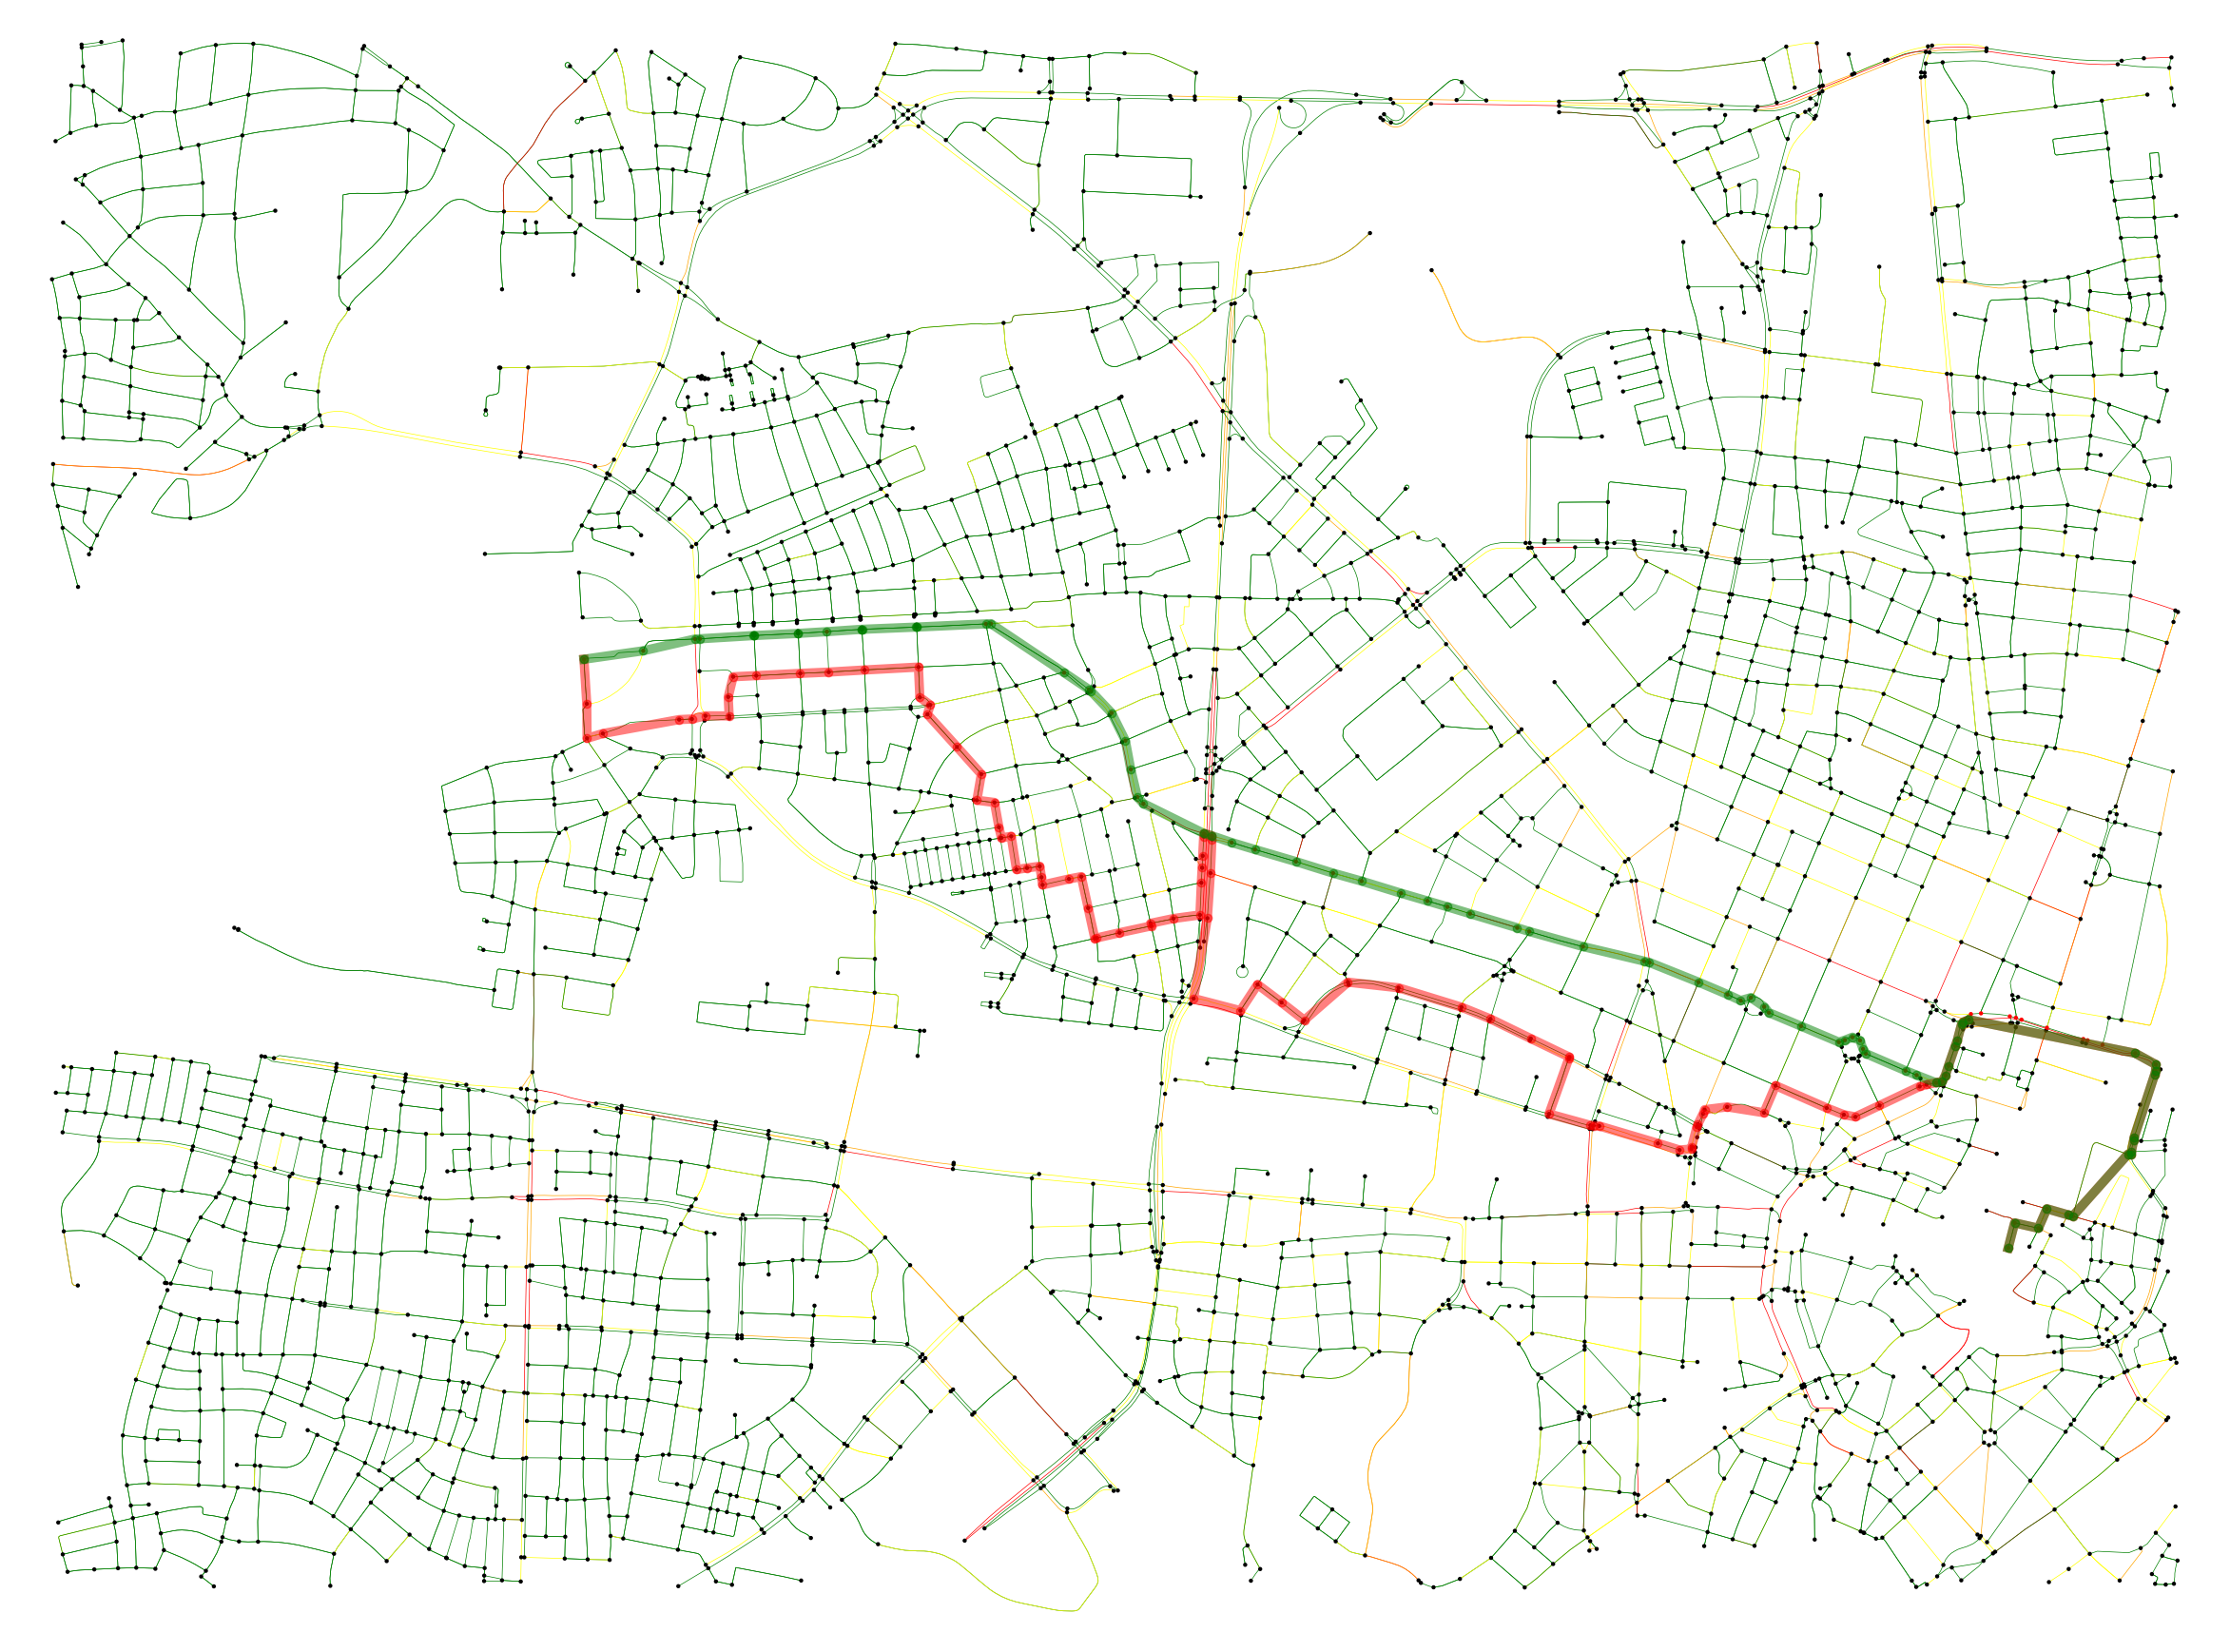

In [200]:
#build custom cost for the edges

for edge in munich_graph_accident.edges:
    munich_graph_accident.edges[edge]['cost'] = munich_graph_accident.edges[edge]['length'] + 500*munich_graph_accident.edges[edge]['total_accidents']

fig, ax = ox.plot_graph(munich_graph_accident, node_color=node_colors, edge_color=edge_colors,figsize=(30, 30), node_size=10, edge_linewidth=0.5, show=False, close=False,bgcolor='white')

route_ox_cost = nx.shortest_path(munich_graph_accident, nodes_start, nodes_end, weight='cost')
ax.plot([munich_graph_accident.nodes[x]['x'] for x in route_ox_cost],[munich_graph_accident.nodes[x]['y'] for x in route_ox_cost], c="red", linewidth=7,zorder=4,alpha=0.5,marker='o')
ax.plot([munich_graph_accident.nodes[x]['x'] for x in route_ox],[munich_graph_accident.nodes[x]['y'] for x in route_ox], c="green", linewidth=7,zorder=4,alpha=0.5,marker='o')

shortest_accidents = get_route_accidents(munich_graph_accident, route_ox, accident_type='total_accidents')
safer_accidents = get_route_accidents(munich_graph_accident, route_ox_cost, accident_type='total_accidents')
print("Number of accidents shortest:", shortest_accidents)
print("Number of accidents safer:", safer_accidents)

fig.savefig('munich_route_comparison.png', dpi=300)

In [197]:
# add accidents of the nodes to the edges

for edge in munich_graph_accident.edges:
    munich_graph_accident.edges[edge]['total_accidents'] = munich_graph_accident.nodes[edge[0]]['num_accidents'] + munich_graph_accident.nodes[edge[1]]['num_accidents'] + munich_graph_accident.edges[edge]['num_accidents']

shortest_accidents_nodes = get_route_accidents(munich_graph_accident, route_ox, accident_type='total_accidents')
safer_accidents_nodes = get_route_accidents(munich_graph_accident, route_ox_cost, accident_type='total_accidents')
print("Number of accidents shortest:", shortest_accidents_nodes)
print("Number of accidents safer:", safer_accidents_nodes)


Number of accidents shortest: 165
Number of accidents safer: 121


In [ ]:
def number_of_accidents(route,radius=0.1):
    route_ngb = find_neighbors_for_route(route, tree, radius)
    num_accidents = 0
    for i,node in enumerate(route_nodes):
        for ngb_rank in route_ngb[i]:
            num_accidents += munich_graph_accident.nodes[node_ids[ngb_rank]]['num_accidents']
        # if 0 < i < len(route_nodes)-1:
        try :
            num_accidents += munich_graph_accident[route_nodes[i-1]][route_nodes[i]]['num_accidents']
            num_accidents += munich_graph_accident[route_nodes[i+1]][route_nodes[i]]['num_accidents']


        except:
            pass


    return num_accidents

def edges_from_route(route_nodes):
    edges = []
    for i,node in enumerate(route_nodes):
        if 0 < i < len(route_nodes)-1:
                edges.append((route_nodes[i-1],route_nodes[i]))
    return edges
    
route_edges = list(zip(route_nodes[:-1], route_nodes[1:]))

node_colors = ['red' if node in route_nodes else 'black' for node in munich_graph_accident.nodes()]
num_accidents = number_of_accidents(route_xy)
print("Number of accidents:", num_accidents)